### GenreBot : Using Natural Language Processing in Music Marketing

For background on this project, please see the [README](../README.md).

**Notebooks**
- [Data Acquisition](./01_data_acquisition.ipynb)
- [Data Cleaning](./02_data_cleaning.ipynb)
- Exploratory Data Analysis (this notebook)
- [Modeling](./04_modeling.ipynb)
- [Experiments](./04a_experiments.ipynb)
- [Results and Recommendations](./05_results.ipynb)

**In this notebook, you'll find explorations related to:**
- Baseline accuracy
- Unique post authors and genre crossover
- Time distribution of posts per genre
- A quick survey of post lengths per genre
- Interesting correlations in the data

In [54]:
# usual imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Assumptions/approach:**:
- The goal of this notebook is really to "play" with the data, with an eye towards understanding whether we've got the right columns for our model, and looking for any oddities that might cause problems later.
- Much of this will probably not be used in the final production model!

In [55]:
# Read in the results of notebook 02

df = pd.read_csv('../data/clean_posts.csv')

In [56]:
# Reminder of what we have

df.head()

,author,created_utc,id,num_comments,score,selftext,subreddit,title,period,all_text,all_text_len,all_text_word_len
0,discord,1221835135,72cy3,16,5,NaN,jazz,Anyone know of any dark / evil sounding jazz?,1,Anyone know of any dark evil sounding jazz,42,8
1,smacfarl,1222039404,72p6u,5,0,NaN,jazz,In honor of Soil &amp; Pimp showing us how it'...,1,In honor of Soil Pimp showing us how it's done...,114,21
2,[deleted],1223963408,76zmj,2,2,NaN,jazz,anybody have that record of Charlie Christian ...,1,anybody have that record of Charlie Christian ...,145,26
3,smacfarl,1224683862,78nrr,4,5,NaN,jazz,New Topline Image for Jazz subreddit. Suggesti...,1,New Topline Image for Jazz subreddit Suggestio...,73,11
4,ChefEspeff,1235783273,80wtq,10,2,NaN,jazz,"Teaching yourself Jazz Piano, is it possible?",1,Teaching yourself Jazz Piano is it possible,43,7


- We'll get our baseline accuracy here, just to get a feel for how our classes are distributed. For more info on why we're focusing on accuracy, please see the next notebook, [Modeling](./04_modeling.ipynb).

In [57]:
# may as well check our baseline accuracy - should be pretty even though

df['subreddit'].value_counts(normalize = True)

classicalmusic     0.250804
popheads           0.250427
jazz               0.250327
electronicmusic    0.248442
Name: subreddit, dtype: float64

**Conclusions:**
- This distribution of classes (i.e., subreddits) looks pretty good - about 25% each. We knew were going to lose a few more posts in the **electronicmusic** subreddit based on our cleaning, but it still looks like an acceptable loss.

- Now, we'll take a look at some info about our unique post authors. In addition to satisfying general curiosity, this will point out whether any of our subreddits have disproportionately prolific authors whose writing style might overly bias our model.

In [58]:
# How many unique users across all subreddits?

len(df['author'].unique())

25120

In [59]:
# How about unique users per subreddit?

df.groupby('subreddit')['author'].nunique()

subreddit
classicalmusic     7072
electronicmusic    6797
jazz               6997
popheads           4656
Name: author, dtype: int64

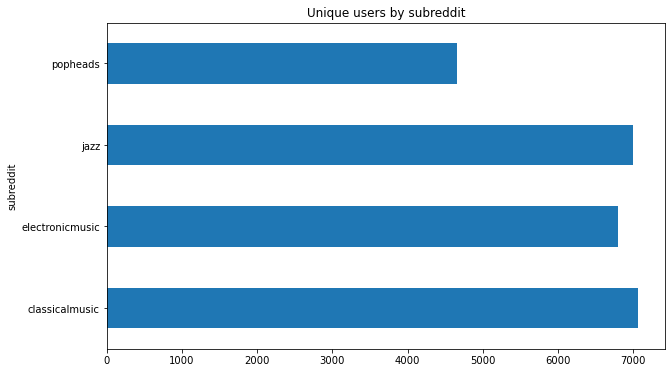

In [85]:
# Let's visualize that
plt.figure(figsize = (10, 6))
plt.title('Unique users by subreddit')
bar = df.groupby('subreddit')['author'].nunique().plot.barh()
bar.get_figure().savefig('../visualizations/unique_users.png', facecolor = 'white', transparent = False);


**Conclusions:**
- 25,000 authors across about 40,000 posts seems pretty reasonable overall.
- The significantly lower number of unique users in **popheads** makes me think we should not use that subreddit for our initial training - maybe we can save it for an experiment though!
- The fact that the sum of these is greater than the overall number of unique users means there are probably some crossover authors - we'll take a look at these next.

In [60]:
# Establish sets of unique authors for each genre
classical_authors = set(df[df['subreddit'] == 'classicalmusic']['author'])
jazz_authors = set(df[df['subreddit'] == 'jazz']['author'])
electronicmusic_authors = set(df[df['subreddit'] == 'electronicmusic']['author'])
popheads_authors = set(df[df['subreddit'] == 'popheads']['author'])

In [61]:
# We'll take a look at a few permutations
# Classical and jazz:

len(jazz_authors.intersection(classical_authors))

196

In [62]:
# jazz and pop:
len(jazz_authors.intersection(popheads_authors))

33

In [63]:
# pop and electronic:
len(popheads_authors.intersection(electronicmusic_authors))

44

**Conclusions**:
- The crossover data doesn't really tell us anything special about our modeling strategy, but it is certainly interesting - lots of crossover between classical and jazz, but almost none between jazz and pop!

- Next, we'll take a look at how the posts are distributed across time for each genre. Just looking for any interesting patterns here.

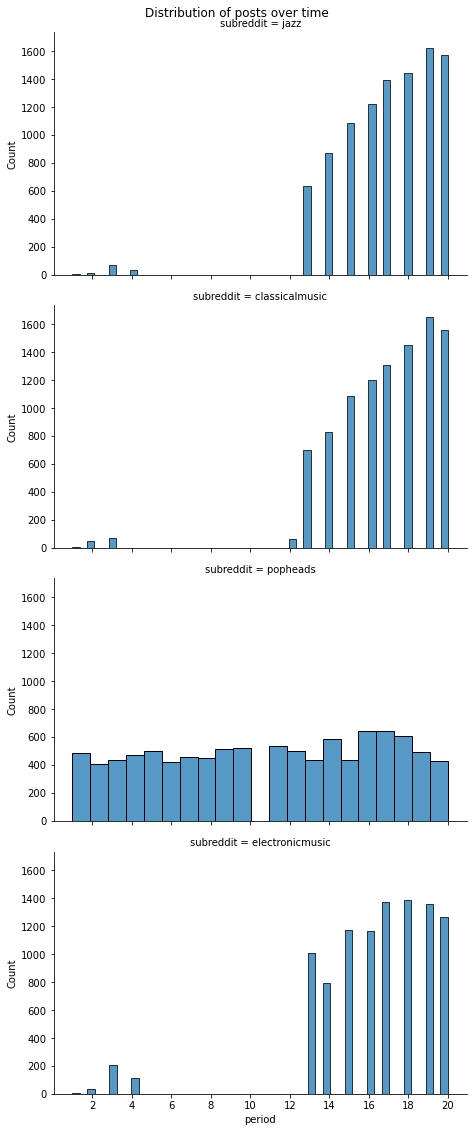

In [64]:
# how do the period histograms look?

# Thanks to https://seaborn.pydata.org/tutorial/axis_grids.html for FacetGrid
# and https://stackoverflow.com/questions/59204749/matplotlib-savefig-background-always-transparent for tweaks

g = sns.FacetGrid(df, row = 'subreddit', height = 4, aspect = 1.67)
plt.xticks(range(0, 21, 2), range(0, 21, 2))
plt.suptitle('Distribution of posts over time')
g.map(sns.histplot, 'period')
g.savefig('../visualizations/posts_over_time.png', facecolor = 'white', transparent = False);

**Conclusions**:
- Interesting that there's a similar gap between periods 5-13 in 3 of the 4 genres, but **electronicmusic** has stayed pretty steady across its lifetime. Not necessarily salient to modeling, but a pattern nonetheless!

- Next we'll take a look at the character and word length distributions.

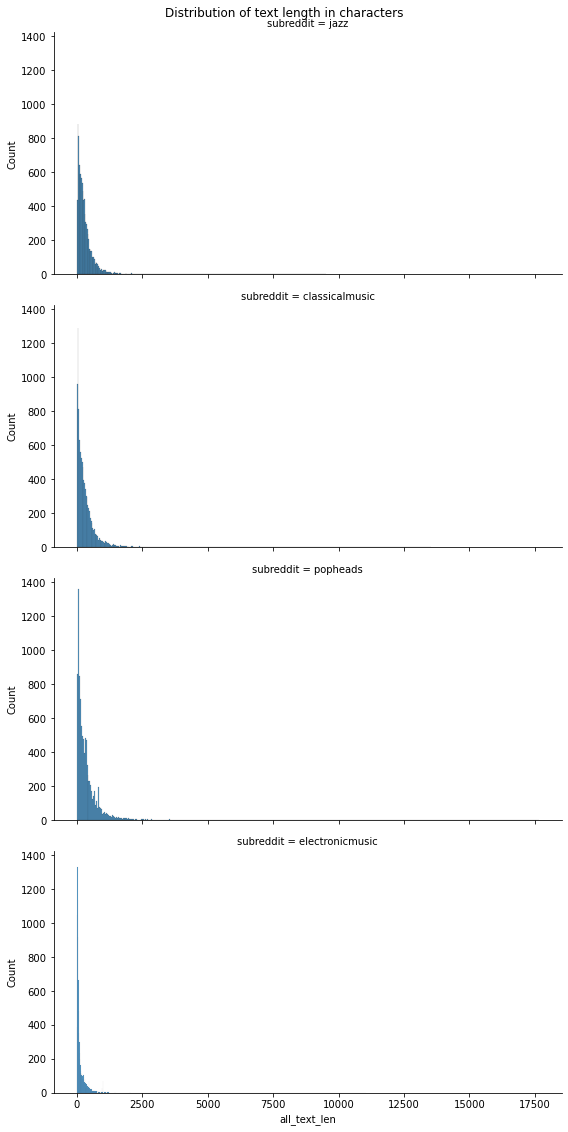

In [65]:
# how do the character length histograms look?

g = sns.FacetGrid(df, row = 'subreddit', height = 4, aspect = 2)
plt.suptitle('Distribution of text length in characters')
g.map(sns.histplot, 'all_text_len')
g.savefig('../visualizations/text_len_char_hist.png', facecolor = 'white', transparent = False);

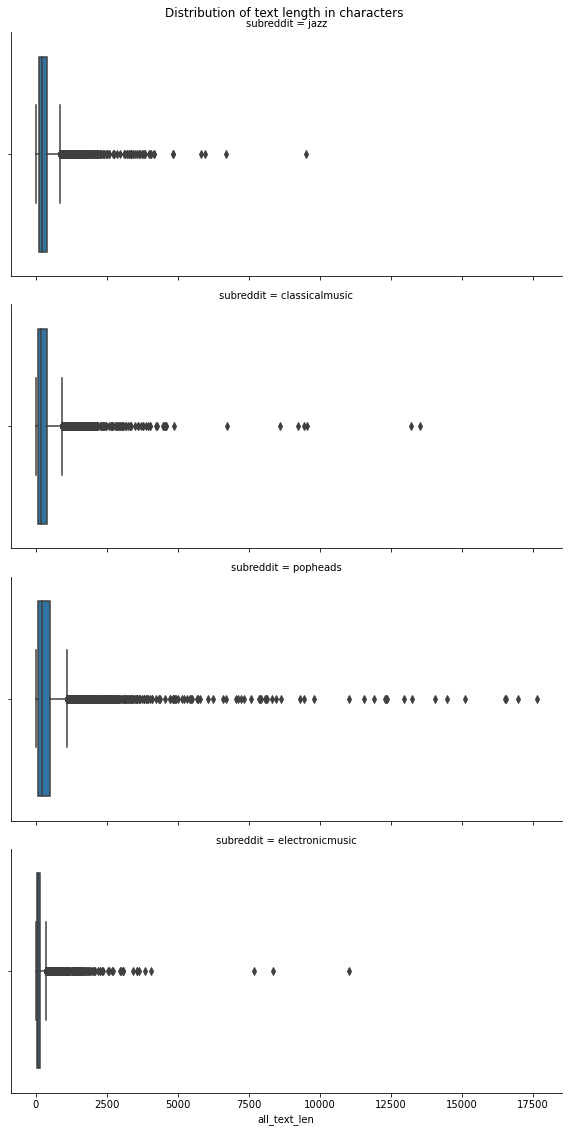

In [66]:
# how about those outliers? maybe boxplots would be good

g = sns.FacetGrid(df, row = 'subreddit', height = 4, aspect = 2)
plt.suptitle('Distribution of text length in characters')
g.map(sns.boxplot, 'all_text_len', order = 'all_text_len')
g.savefig('../visualizations/text_len_char_box.png', facecolor = 'white', transparent = False);

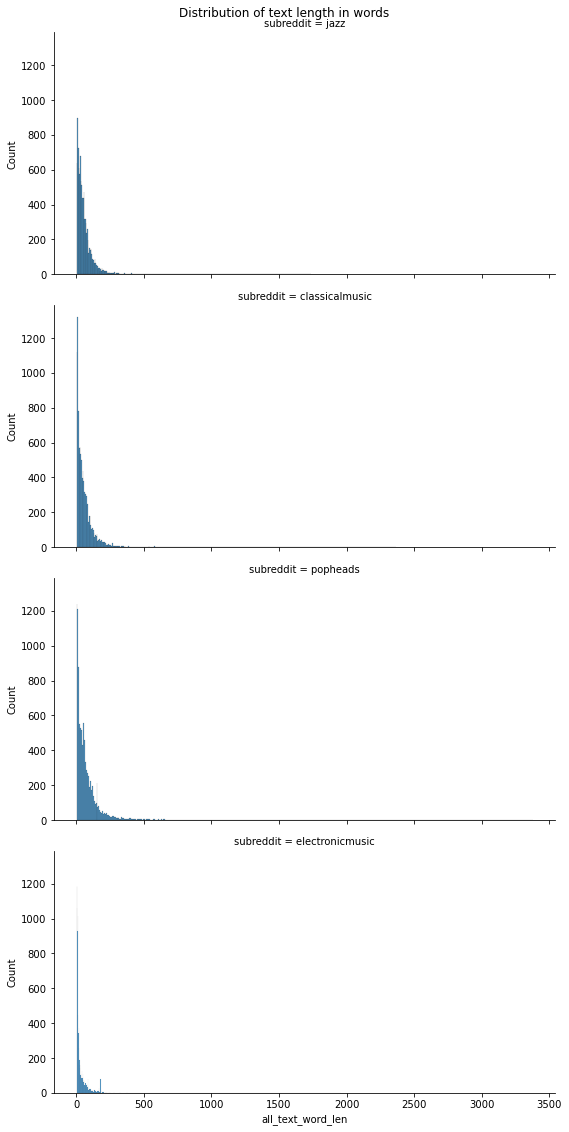

In [67]:
# how do the word length histograms look?

g = sns.FacetGrid(df, row = 'subreddit', height = 4, aspect = 2)
plt.suptitle('Distribution of text length in words')
g.map(sns.histplot, 'all_text_word_len')
g.savefig('../visualizations/text_len_word_hist.png', facecolor = 'white', transparent = False);

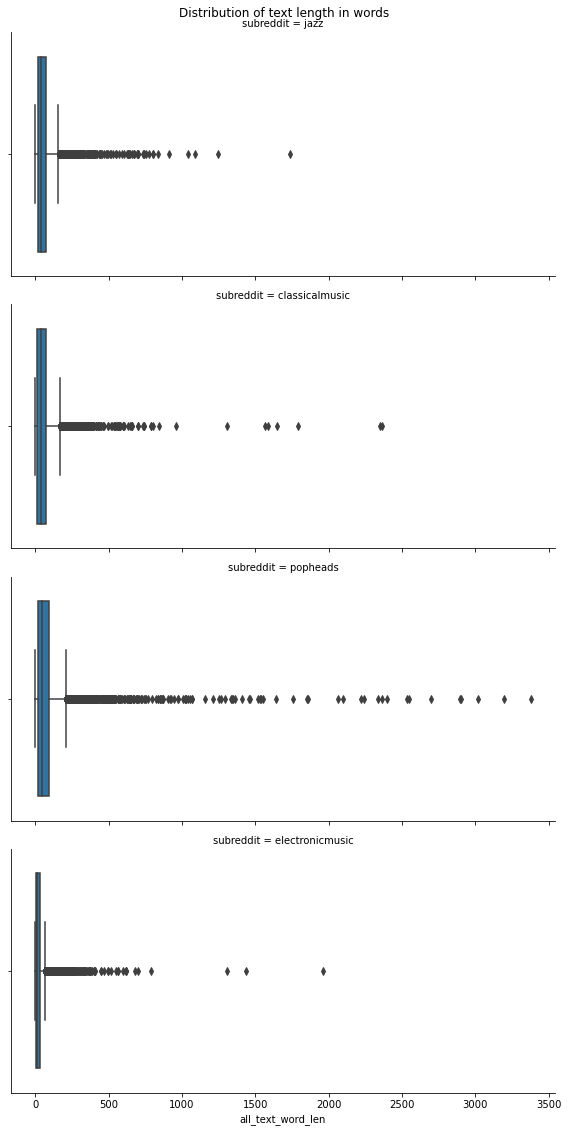

In [68]:
# how about those outliers?
g = sns.FacetGrid(df, row = 'subreddit', height = 4, aspect = 2)
plt.suptitle('Distribution of text length in words')
g.map(sns.boxplot, 'all_text_word_len', order = 'all_text_word_len')
g.savefig('../visualizations/text_len_word_box.png', facecolor = 'white', transparent = False);

**Conclusions**:
- The overall profile of **electronicmusic** looks significantly different from the others - much more compressed inter-quartile range - which makes me think (again) that we should not focus on it for this initial training.
- I would say the most similar profiles are **classicalmusic** and **jazz**, which makes me favor using them for our model.

- And finally, we'll see if there are any surprising correlations to observe:

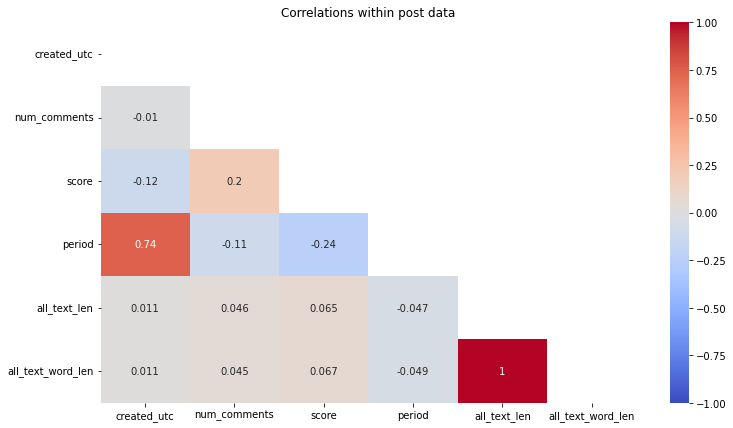

In [72]:
# let's see if there are any interesting correlations

corr = df.corr()
plt.figure(figsize = (12, 7))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.title('Correlations within post data')
hm = sns.heatmap(df.corr(), vmin = -1, vmax = 1, cmap = 'coolwarm', annot = True, mask = mask)
hm.get_figure().savefig('../visualizations/corr_heatmap.png', facecolor = 'white', transparent = False);

**Conclusions:**
- Not surprising that period and created_utc correlate strongly - they both have to do with the time of post creation.
- Similarly unsurprising that text length in characters and text length in words correlate strongly.
- The only other correlation of note is # of comments vs. score, which makes me think that Reddit's scoring process somehow incorporates # of comments as part of its calculation.
- No particular red flags here.

**FINAL NOTES:**
- All visualizations from this EDA exercise can be found in the **visualizations** directory.
- There is no data output from this notebook.
- The next notebook in the series is [Modeling](./04_modeling.ipynb).